In [1]:
import copy
from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import Draw
from rdkit.Chem import Recap,BRICS
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import display

In [2]:
## https://iwatobipen.wordpress.com/2020/01/23/cut-molecule-to-ring-and-linker-with-rdkit-rdkit-chemoinformatics-memo/

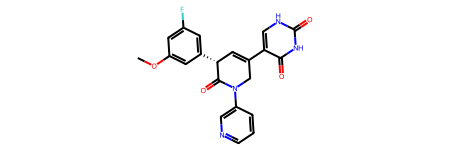

In [3]:
mol1 = Chem.MolFromSmiles("C1CCNCC1")
mol2 = Chem.MolFromSmiles("c1ccccc1")
mol3 = Chem.MolFromSmiles("C1CC1CC")
mol4 = Chem.MolFromSmiles("C1CC1CCC2CCOC2")
mol5 = Chem.MolFromSmiles("C1CCC2CCCCC2C1")
mol6 = Chem.MolFromSmiles("OC1CC2(C1)CCCC2")
mol7 = Chem.MolFromSmiles("CC1CCN(CC1N(C)C2=NC=NC3=C2C=CN3)C(=O)CC#N")
mol8 = Chem.MolFromSmiles("c1ccccc1c2ccccc2OC")
mol9 = Chem.MolFromSmiles("CC1=C(C=C(C=C1)NC(=O)C2=CC=C(C=C2)CN3CCN(CC3)C)NC4=NC=CC(=N4)C5=CN=CC=C5")
mol10 = Chem.MolFromSmiles("C1CCCC1CCCOCOCOCOCOCc1ccccc1")
mol11 = Chem.MolFromSmiles("n12c(ncc(c1[C@@H](OC)C)NC(=O)Nc1ccnc(c1)C(F)(F)F)cc(n2)Cl")
mol12 = Chem.MolFromSmiles("c1(c2c(ncc1NC(=O)Nc1ccnc(c1)C(F)(F)F)n(c(n2)C)C)C1CC1")
mol13 = Chem.MolFromSmiles("O=c1c(C2=C[C@H](C(=O)N(C2)c2cnccc2)c2cc(F)cc(OC)c2)c[nH]c(=O)[nH]1")
mols = [mol13] #[mol11, mol12, mol13]
for mol in mols:
    display(mol)
#display(mols[0])

In [4]:
def is_in_samering(idx1, idx2, bond_rings):
    for bond_ring in bond_rings:
        if idx1 in bond_ring and idx2 in bond_ring:
            return True
    return False

In [5]:
def getLinkerbond(mol, useScaffold=True):
    res = []
    for atom in mol.GetAtoms():
        atom.SetIntProp("orig_idx", atom.GetIdx())
    for bond in mol.GetBonds():
        bond.SetIntProp("orig_idx", bond.GetIdx())
     
    if useScaffold:
        mol = MurckoScaffold.GetScaffoldForMol(mol)
         
    ring_info = mol.GetRingInfo()
    bond_rings = ring_info.BondRings()
    ring_bonds = set()
    for ring_bond_idxs in bond_rings:
        for idx in ring_bond_idxs:
            ring_bonds.add(idx)
    all_bonds_idx = [bond.GetIdx() for bond in mol.GetBonds()]
    none_ring_bonds = set(all_bonds_idx) - ring_bonds
    for bond_idx in none_ring_bonds:
        bgn_idx = mol.GetBondWithIdx(bond_idx).GetBeginAtomIdx()
        end_idx = mol.GetBondWithIdx(bond_idx).GetEndAtomIdx()
        if mol.GetBondWithIdx(bond_idx).GetBondTypeAsDouble() == 1.0:
            if mol.GetAtomWithIdx(bgn_idx).IsInRing()+mol.GetAtomWithIdx(end_idx).IsInRing() == 1:
                bond = mol.GetBondWithIdx(bond_idx)
                orig_idx = bond.GetIntProp("orig_idx")
                res.append(orig_idx)
            elif not is_in_samering(bgn_idx, end_idx, bond_rings) and mol.GetAtomWithIdx(bgn_idx).IsInRing()+mol.GetAtomWithIdx(end_idx).IsInRing() == 2:
                bond = mol.GetBondWithIdx(bond_idx)
                orig_idx = bond.GetIntProp("orig_idx")
                res.append(orig_idx)            
    return res

(<rdkit.Chem.rdchem.Mol at 0x7f91aa5d1f50>,
 <rdkit.Chem.rdchem.Mol at 0x7f91aa5d0c10>)

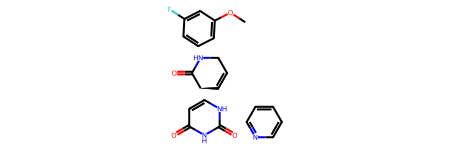

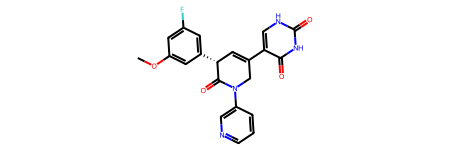

In [6]:
for mol in mols:
    bonds = getLinkerbond(mol)
    if bonds:
        res = Chem.FragmentOnBonds(mol, bonds, addDummies=False)
        res_mols = Chem.GetMolFrags(res, asMols=True)
        #print(res)
        display(res_mols, res, mol)
    else:
        display(mol)
    
smis = [Chem.MolToSmiles(x,True) for x in Chem.GetMolFrags(res,asMols=True)]
smis

#sdfFile2d = open('junk/junk.sdf', 'a')
sdfFile3d = open('junk/junk_3d.sdf', 'a')

for smi in smis:
    mol = Chem.MolFromSmiles(smi)
    mol = Chem.AddHs(mol)
    # save 2D sdf file
    #sdf = Chem.SDWriter(sdfFile2d)
    #sdf.write(mol)
        
    # save 3D sdf file
    writer = Chem.SDWriter(sdfFile3d)
    confIds = Chem.AllChem.EmbedMultipleConfs(mol, 1)
    print(confIds)
    for confId in confIds:
        Chem.AllChem.UFFOptimizeMolecule(mol, confId=confId)
        writer.write(mol, confId=confId)
    

Trying stuff with BRICS

In [4]:
#for mol in mols:
frags = list(Chem.BRICS.BRICSDecompose(mol13, minFragmentSize=5, keepNonLeafNodes=True, returnMols=False))
##if returnMols = False
mols = [Chem.MolFromSmiles(x) for x in frags]

smi = [Chem.MolToSmiles(x,True) for x in mols]
sorted(smi)

## removing dummy atoms from molecules
du = Chem.MolFromSmiles('*')
molh = [Chem.AllChem.ReplaceSubstructs(x,du,Chem.MolFromSmiles('[H]'), True)[0] for x in mols]
display(molh)
smih = [Chem.MolToSmiles(x) for x in molh]
sorted(smih)
#Draw.MolsToGridImage(molh, molsPerRow=4, subImgSize=(200, 200))

#sdfFile2d = open('junk/junk.sdf', 'a')

x = 0
for smi in sorted(smih):
    mol = Chem.MolFromSmiles(smi)
    mol = Chem.AddHs(mol)
    # save 2D sdf file
    sdfFile2d = open('junk/tmp_' +str(x) + '.sdf', 'w')
    writer = Chem.SDWriter(sdfFile2d)
    writer.write(mol)
    x += 1

sdfFile3d = open('junk/junk_brics.sdf', 'a')
for smi in sorted(smih):
    mol = Chem.MolFromSmiles(smi)
    mol = Chem.AddHs(mol)
    #save 3D sdf file
    confIds = Chem.AllChem.EmbedMultipleConfs(mol, 1)
    for confId in range(1):
        Chem.AllChem.UFFOptimizeMolecule(mol, confId=confId)
        writer = Chem.SDWriter(sdfFile3d)
        writer.write(mol, confId=confId)  

[13:29:00] WARNING: not removing hydrogen atom without neighbors
[13:29:00] WARNING: not removing hydrogen atom without neighbors
[13:29:00] WARNING: not removing hydrogen atom without neighbors
[13:29:00] WARNING: not removing hydrogen atom without neighbors
[13:29:00] WARNING: not removing hydrogen atom without neighbors
[13:29:00] WARNING: not removing hydrogen atom without neighbors


In [20]:
## RECAP
pieces = Recap.RecapDecompose(mol13)
pieces
pieces.children
pieces.GetLeaves()

{'*c1cccnc1': <rdkit.Chem.Recap.RecapHierarchyNode at 0x7fc5ca3ce790>,
 '*N1CC(c2c[nH]c(=O)[nH]c2=O)=C[C@@H](c2cc(F)cc(OC)c2)C1=O': <rdkit.Chem.Recap.RecapHierarchyNode at 0x7fc5ca3cf650>}

In [58]:
import random
build = BRICS.BRICSBuild(mols)
random.seed(90)
prods = [next(build) for x in range(17)]
Draw.MolsToGridImage(prods, molsPerRow=4, subImgSize=(200, 200))

RuntimeError: Pre-condition Violation
	getExplicitValence() called without call to calcExplicitValence()
	Violation occurred on line 306 in file Code/GraphMol/Atom.cpp
	Failed Expression: d_explicitValence > -1
	RDKIT: 2023.03.3
	BOOST: 1_78


In [49]:
for mol in mols:
    fragmented=BRICS.BreakBRICSBonds(mol, sanitize=True)
    piece=Chem.GetMolFrags(fragmented,asMols=True)
    piece, fragmented
    #smis = [Chem.MolToSmiles(x,True) for x in Chem.GetMolFrags(piece, asMols=True)]
    #smis
    #Draw.MolsToGridImage(piece)

In [18]:
# Create network from the two molecules
import openfe
from openfe.setup.ligand_network_planning import generate_radial_network
from openfe.setup import LomapAtomMapper

for mol in mols:
    bonds = getLinkerbond(mol)
    if bonds:
        res = Chem.FragmentOnBonds(mol, bonds, addDummies=False)
        res_mols = Chem.GetMolFrags(res, asMols=True)
        tosdf = Chem.SDWriter.write(res, ConfId=1)
        frag = openfe.SmallMoleculeComponent.from_rdkit(tosdf)
        parent = openfe.SmallMoleculeComponent.from_rdkit(mol)
        network = generate_radial_network(ligands=frag,
                                          central_ligand=parent,
                                          mappers=[LomapAtomMapper(threed=True, element_change=False),])
        edges = [edge for edge in network.edges]
        edge = edges[0]
        edge
        #display(res)
    else:
        display(mol)

ArgumentError: Python argument types in
    SDWriter.write(Mol)
did not match C++ signature:
    write(RDKit::SDWriter {lvalue} self, RDKit::ROMol {lvalue} mol, int confId=-1)

In [12]:
pieces = []
smi = []
#for mol in res_mols:
    #fragmented=BRICS.BreakBRICSBonds(mol, sanitize=True)
    #piece=Chem.GetMolFrags(fragmented,asMols=True)
    #pieces.append(piece)
    #smi = Chem.MolToSmiles(piece, True)
    #Draw.MolsToGridImage(smi)
    
smis = [Chem.MolToSmiles(x,True) for x in Chem.GetMolFrags(res,asMols=True)]
smis
for smi in smis:
    junk = Chem.MolFromSmiles(smi)
    Draw.MolsToGridImage(junk)
    
#display(smis)

TypeError: object of type 'Mol' has no len()

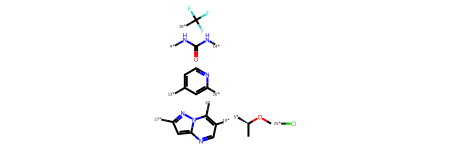

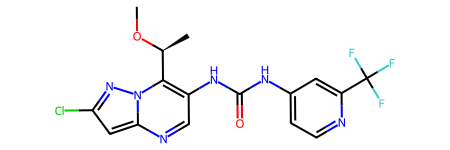

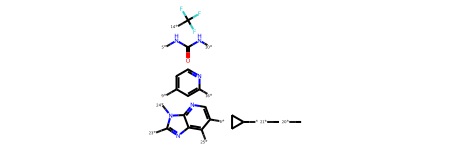

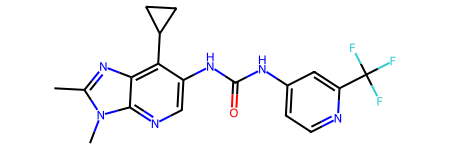

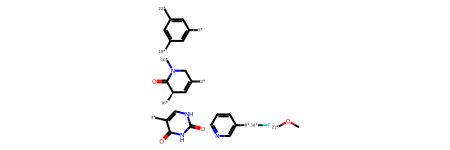

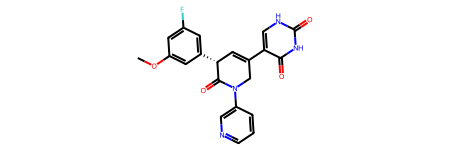

In [88]:
for mol in mols:
    bonds = getLinkerbond(mol, False)
    if bonds:
        res = Chem.FragmentOnBonds(mol, bonds)
        display(res, mol)
    else:
        display(mol)